In [22]:
import numpy as np
import tensorflow as tf
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt


In [23]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [24]:
# Preprocess data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [25]:
# Create a simple CNN model (you can replace this with your own trained model)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [26]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [27]:
# Train the model
model.fit(x_train, y_train, epochs=10, validation_split=0.1, batch_size=64)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3210 - loss: 1.8279 - val_accuracy: 0.5474 - val_loss: 1.2775
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5467 - loss: 1.2668 - val_accuracy: 0.6026 - val_loss: 1.1327
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6166 - loss: 1.0801 - val_accuracy: 0.6600 - val_loss: 0.9894
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6712 - loss: 0.9377 - val_accuracy: 0.6670 - val_loss: 0.9594
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6935 - loss: 0.8718 - val_accuracy: 0.6806 - val_loss: 0.9280
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7242 - loss: 0.7902 - val_accuracy: 0.7004 - val_loss: 0.8964
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7457 - loss: 0.7264 - val_accuracy: 0.7224 - val_loss: 0.8294
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7705 - loss: 0.6599 - val_accurac

In [28]:
# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()


In [29]:
# Create ART classifier with loss function
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), loss_object=loss_object)


In [30]:
# Initialize PGD attack
attack = ProjectedGradientDescent(estimator=classifier, eps=0.1, eps_step=0.01, max_iter=40)

In [31]:
# Iterate over a range of eps values
eps_values = np.linspace(0.01, 0.1, num=10)
accuracies = []

for eps in eps_values:
    # Update the attack with the current eps value
    attack.set_params(**{'eps': eps})

    # Generate adversarial examples
    x_adv = attack.generate(x=x_test)

    # Evaluate model accuracy on adversarial examples
    accuracy = np.mean(np.argmax(classifier.predict(x_adv), axis=1) == np.argmax(y_test, axis=1))
    accuracies.append(accuracy)

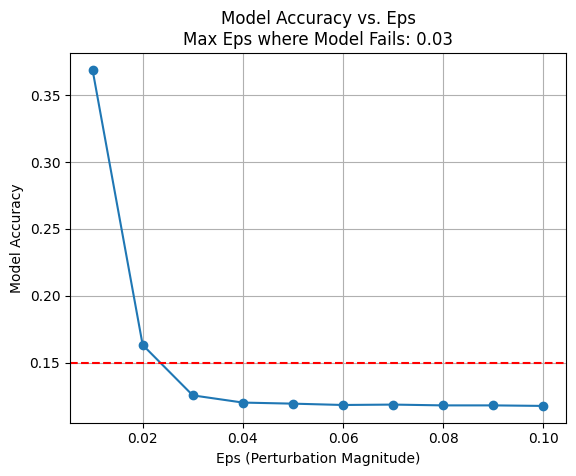

Maximum eps value after which the model fails (accuracy <= 15%): 0.03


In [35]:
# Identify the maximum eps value where accuracy drops below 10%
threshold_accuracy = 0.15
max_eps_fail = eps_values[np.where(np.array(accuracies) <= threshold_accuracy)[0][0]]

# Plot the graph
plt.plot(eps_values, accuracies, marker="o")
plt.axhline(y=threshold_accuracy, color='r', linestyle='--')
plt.xlabel("Eps (Perturbation Magnitude)")
plt.ylabel("Model Accuracy")
plt.title(f"Model Accuracy vs. Eps\nMax Eps where Model Fails: {max_eps_fail:.2f}")
plt.grid(True)
plt.show()

print(f"Maximum eps value after which the model fails (accuracy <= 15%): {max_eps_fail:.2f}")
